In [1]:
import pandas as pd
import json
import spacy
from dataframe import DataFrameCreator
from lucy import Lucy
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from operator import add
from pprint import pprint
STD_FIG_SIZE = (17,4)
# renewable subset
RENEWABLE_SUBSET = ["solar", "solar thermal", "wind", "wave", "hydro", "bio"]
# fossil fuels subset
FOSSIL_SUBSET = ["coal", "oil", "fossil gas"]
ET_COLOUR_MAPPING = {
    "coal": "black",
    "bio": "tomato",
    "oil": "sienna",
    "ccs": "lightpink",
    "fossil gas": "rebeccapurple",
    "hydro": "deepskyblue",
    "wave": "steelblue",
    "nuclear": "lawngreen",
    "solar": "gold",
    "solar thermal": "darkkhaki",
    "wind": "grey"
}
ORG_COLOUR_MAPPING = {
    "steo": "red",
    "ieo": "gold",
    "aeo": "deepskyblue",
    "tech_briefs": "forestgreen" 
}
ET_INDICES = ['fossil gas', 'coal', 'nuclear', 'oil', 'hydro', 'bio', 'wind', 'solar', 'solar thermal', 'ccs', 'wave']



In [2]:
lucy = Lucy()
def fill_null(counter_dict):
    for energy in lucy.energy_clusters.keys():
        if energy not in counter_dict.keys():
            counter_dict[energy] = 0
    return counter_dict
# pre_df = lucy._load_energy_count_df("energy_count_df.pickle")
df = lucy.load_df("lucy.pickle")
only_ieo_aeo = df['doc_category'].apply(lambda x: x=="aeo" or x=="ieo")
df = df[only_ieo_aeo]
df = DataFrameCreator.annotate_year("doc_year_map.json", df)

/data/greyroads/energy-roadmap/dataframe.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = years


In [4]:
# Let's see the prevalence of energy counts across the entire corpus
stem_counts = df['lucy_energy_counts'].aggregate(lambda x: sum(x, Counter()))
# pprint(total_counts)

# compare it to different df
lemma_counts = lemm_df['coref_energy_counts'].aggregate(lambda x: sum(x, Counter()))

# pprint(last_week)
df_data = {"week": ["lemma", "stem"]}
for key in stem_counts:
    df_data[key] = [lemma_counts[key], stem_counts[key]]

comparison_df = pd.DataFrame(df_data)
comparison_df

,week,coal,oil,fossil gas,nuclear,solar,wind,bio,hydro,wave,solar thermal,ccs
0,lemma,17726,27640,29422,6969,3024,4081,6880,1107,215,352,107
1,stem,17726,27640,29067,6977,3035,4083,7165,2162,215,369,108


In [8]:
def populate_terms(terms, lucy_inst):
    populated_terms = {}
    for cluster in energy_clusters:
        cur_cluster = energy_clusters[cluster]
        if lucy_inst.stem:
            cur_cluster = [lucy_inst._preprocess(x)._.stemmed_doc for x in cur_cluster]
        else:
            cur_cluster = [lucy_inst._preprocess_spacy(x) for x in cur_cluster]
        cluster_dict = {}
        # stage 1
        # check if term is in cluster
        for term in total_terms:
            if term in cur_cluster:
                cluster_dict[term] = total_terms[term]
        # stage 2
        # adds all keywords that don't exist in total_terms
        for keyword in cur_cluster:
            if keyword not in cluster_dict:
                cluster_dict[keyword] = 0
        populated_terms[cluster] = cluster_dict
    return populated_terms

with open("energy_technology.json", "r") as fp:
    ets = json.load(fp)
stemmed = {}
lemmad = {}
_lucy = Lucy(stem=True)
with open("energy_technology.json", "r") as fp:
    energy_clusters = json.load(fp)
total_terms = df['coref_energy_terms'].aggregate(lambda x: sum(x, Counter()))
t1 = populate_terms(total_terms, _lucy)
for energy_tech in ets:
    stemmed[energy_tech] = [_lucy._preprocess(keyword)._.stemmed_doc for keyword in ets[energy_tech]]
_lucy = Lucy()
total_terms = lemm_df['coref_energy_terms'].aggregate(lambda x: sum(x, Counter()))
t2 = populate_terms(total_terms, _lucy)
for energy_tech in ets:
    lemmad[energy_tech] = [_lucy._preprocess_spacy(keyword) for keyword in ets[energy_tech]]

In [9]:
pprint(stemmed['hydro'])
print(sorted(t1['hydro'].items(), key= lambda x: x[0]))
print("===")
pprint(lemmad['hydro'])
print(sorted(t2['hydro'].items(), key= lambda x: x[0]))

['hydro',
 'hydroelectr',
 'hydro storag',
 'hydro-electr power plant',
 'hydro-electr power station',
 'hydroelectr develop',
 'hydroelectr power',
 'pump hydro']
[('hydro', 534), ('hydro storag', 5), ('hydro-electr power plant', 0), ('hydro-electr power station', 0), ('hydroelectr', 1334), ('hydroelectr develop', 13), ('hydroelectr power', 243), ('pump hydro', 33)]
===
['hydro',
 'hydroelectricity',
 'hydro storage',
 'hydro-electric power plant',
 'hydro-electric power station',
 'hydroelectric development',
 'hydroelectric power',
 'pumped hydro']
[('hydro', 560), ('hydro storage', 5), ('hydro-electric power plant', 0), ('hydro-electric power station', 0), ('hydroelectric development', 12), ('hydroelectric power', 243), ('hydroelectricity', 280), ('pumped hydro', 7)]


32066

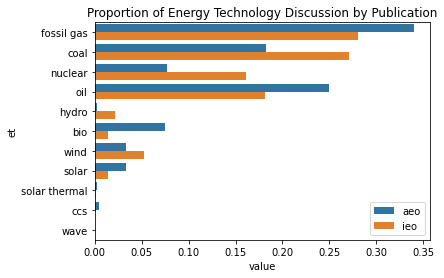

In [73]:
"""
This cell will be analysis between organisations of proportion of keywords that relate to each technology
i.e. for tech_briefs, out of all the times energy technologies are mentioned, how often is 'bio' the technology mentioned?
answer: ~40% (see graph below)
"""
from collections import defaultdict
res = df.groupby("doc_category")['lucy_counts'].aggregate(lambda x: sum(x, Counter()))
df_list = []
aeo_total = sum(res['aeo'].values())
ieo_total = sum(res['ieo'].values())
aeo = [["aeo", i, res['aeo'][i] / aeo_total] for i in ET_INDICES]
ieo = [["ieo", i, res['ieo'][i] / ieo_total] for i in ET_INDICES]
df_list.extend(aeo)
df_list.extend(ieo)
plot_df = pd.DataFrame(data=df_list, columns=["publication", "et", "value"])
# penguins = sns.load_dataset("tips")
# penguins
g = sns.barplot(data=plot_df, hue="publication", y="et", x="value").set(title="Proportion of Energy Technology Discussion by Publication")
plt.legend(loc='lower right')
aeo_total
# WIDTH = 0.2
# IND = np.arange(len(res[res.keys()[0]].keys()))

# def plot_proportion_graph(dataset, figure_num, title, xlabel, ylabel):
#     """
#     Plots dataset
#     """
#     plt.figure(figure_num, figsize=STD_FIG_SIZE)
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     labels = None
#     for i, key in enumerate(dataset.keys()):
#         fill_null(dataset[key])
#         total_counts = sum(dataset[key].values())
#         sorted_data = sorted(dataset[key].items(), key= lambda x: x[0])
#         if not labels:
#             labels = [x[0] for x in sorted_data]
#         sorted_values = [(el[1] / total_counts) for el in sorted_data]
#         x = IND + (WIDTH * i)
#         plt.bar(x, sorted_values, width=WIDTH, label=key, color=ORG_COLOUR_MAPPING[key])
#     plt.xticks(IND + WIDTH, labels)
#     plt.legend(loc="best")
#     plt.show()

# plot_proportion_graph(res, 1, "Proportion of Energy Technology Discussion by Publication", "energy technology", "frequency")


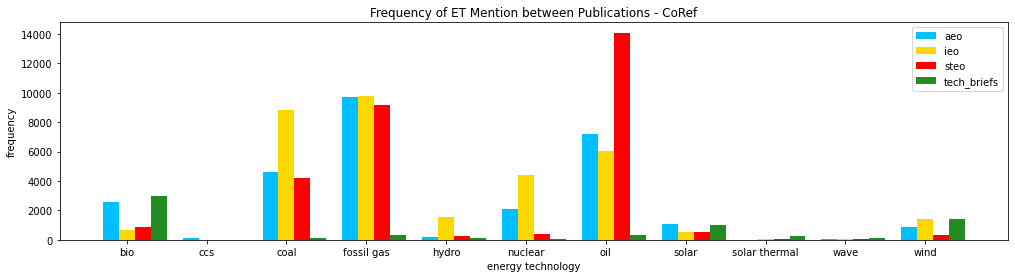

In [11]:
# Let's see how prevalent each energy technology is discussed between publications
WIDTH = 0.2
IND = np.arange(len(lucy.energy_clusters.keys()))

def plot_graph(dataset, type_, figure_num):
    plt.figure(figure_num, figsize=STD_FIG_SIZE)
    plt.title(f"Frequency of ET Mention between Publications - {type_}")
    plt.xlabel("energy technology")
    plt.ylabel("frequency")
    labels = [x for x in sorted(lucy.energy_clusters.keys())]
    for i, key in enumerate(dataset.keys()):
        fill_null(dataset[key])
        sorted_data = [el[1] for el in sorted(dataset[key].items(), key= lambda x: x[0])]
        plt.bar(IND + (WIDTH * i), sorted_data, width=WIDTH, label=key, color=ORG_COLOUR_MAPPING[key])
    plt.xticks(IND + WIDTH, labels)
    plt.legend(loc="best")
    plt.show()

# dataset2 = lucy.get_energy_count_by_x(df, groupby="doc_category", column="raw_energy_counts")
# plot_graph(dataset2, "Raw", 2)
dataset3 = lucy.get_energy_count_by_x(df, groupby="doc_category", column="coref_energy_counts")
plot_graph(dataset3, "CoRef", 3)

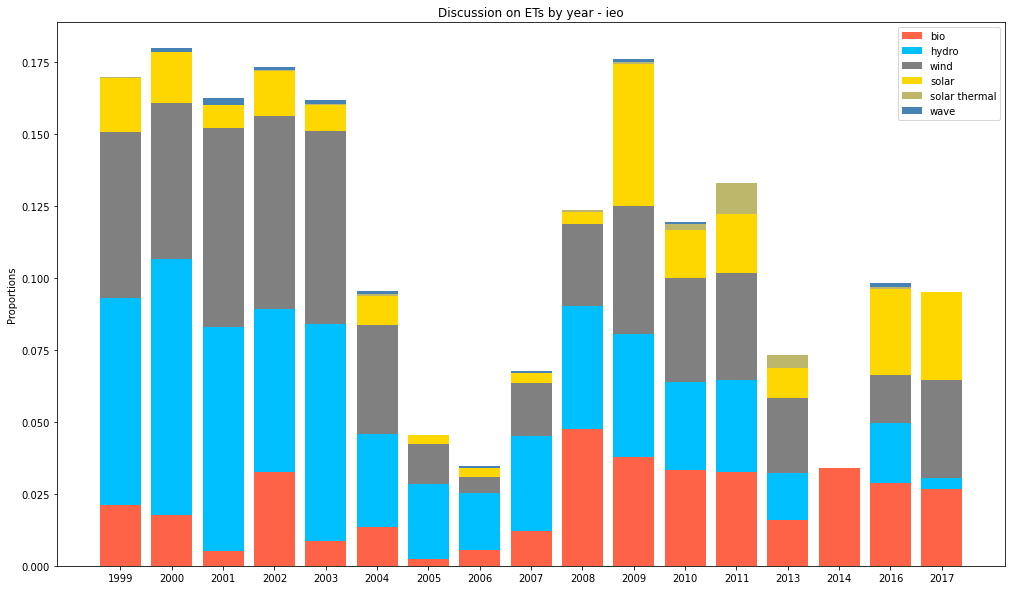

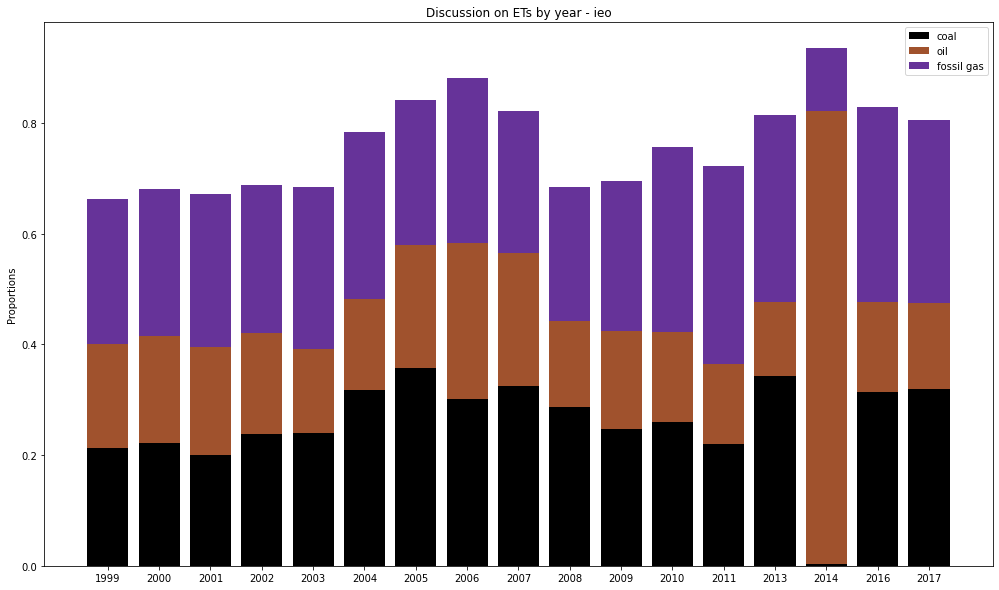

In [12]:
# Let's have a look at how often an energy technology is mentioned over time
# within a publication
PUBLICATION = "ieo"
dataset = lucy.get_energy_count_by_x(df[df["doc_category"] == PUBLICATION], groupby=["year"], column="coref_energy_counts")
labels = [year for year in dataset.keys()]

def create_subset_stacked_bar(dataset, subset=[]):
    fig, ax = plt.subplots(figsize=(17,10))
    final_data = {}
    for year, data in dataset.items():
        fill_null(data)
        total = sum(data.values())
        for et in data:
            if (subset == []) or (et in subset):
                if et not in final_data:
                    final_data[et] = []
                final_data[et].append(data[et] / total)
    prev_dataset = None
    for i, (key, values) in enumerate(final_data.items()):
        ax.bar(labels, values, label=key, bottom=prev_dataset, color=ET_COLOUR_MAPPING[key])
        ax.set_ylabel('Proportions')
        ax.set_title(f'Discussion on ETs by year - {PUBLICATION}')
        ax.legend()
        if not prev_dataset:
            prev_dataset = values
        else:
            prev_dataset = list( map( add, prev_dataset, values))
    plt.show()
        
# create_stacked_bar(dataset)
create_subset_stacked_bar(dataset, RENEWABLE_SUBSET)
create_subset_stacked_bar(dataset, FOSSIL_SUBSET)

In [13]:
# Let's see the prevalence of energy terms across the entire corpus
total_terms = df['coref_energy_terms'].aggregate(lambda x: sum(x, Counter()))
with open("energy_technology.json", "r") as fp:
    energy_clusters = json.load(fp)

def populate_terms(terms, lucy_inst):
    populated_terms = {}
    for cluster in energy_clusters:
        cur_cluster = energy_clusters[cluster]
        if lucy_inst.stem:
            cur_cluster = [lucy_inst._preprocess(x)._.stemmed_doc for x in cur_cluster]
        else:
            cur_cluster = [lucy_inst._preprocess_spacy(x) for x in cur_cluster]
        cluster_dict = {}
        # stage 1
        # check if term is in cluster
        for term in total_terms:
            if term in cur_cluster:
                cluster_dict[term] = total_terms[term]
        # stage 2
        # adds all keywords that don't exist in total_terms
        for keyword in cur_cluster:
            if keyword not in cluster_dict:
                cluster_dict[keyword] = 0
        populated_terms[cluster] = cluster_dict
    return populated_terms

cluster_terms = populate_terms(total_terms, lucy)
# with open("cluster_terms.json", "w") as wfp:
#     json.dump(cluster_terms, wfp)
from pprint import pprint
pprint(cluster_terms)



{'bio': {'bio': 167,
         'bio-base industry': 0,
         'bio-industry': 0,
         'biodiesel': 600,
         'bioenergy': 0,
         'bioethanol': 280,
         'biofuel': 1529,
         'biogas': 0,
         'biomass': 1603,
         'biomass energy': 0,
         'biomass fuel': 74,
         'biomass power': 37,
         'biomaterial': 0,
         'ethanol': 1940,
         'methanol': 299},
 'ccs': {'carbon dioxide capture': 0,
         'ccs': 0,
         'ccus': 0,
         'co2 capture and sequestration': 0,
         'co2 capture and storage': 0},
 'coal': {'coal': 16938,
          'coal by-product industry': 0,
          'coal field': 11,
          'coal gasification': 0,
          'coal hydrogenation': 0,
          'coal industry': 0,
          'coal liquefaction': 0,
          'coal mine': 370,
          'coal mining': 0,
          'coal policy': 0,
          'coal processing': 0,
          'coal waste': 0,
          'coal-burn power station': 0,
          'coalmine pol

In [14]:
## Here we will analyse over time, in text that has header relating to costs, prevalence of different energy technologies ##
keywords = ["cost", "costs", "prices", "projections", "p r i c e s", "economic", "e c o n o m i c"]
def filter_fn(row):
    if not row['coref_para_text']:
        return False
    for key in keywords:
        if key in row['coref_para_text'].lower():
            return True
        else:
            return False
    return False

mapping = df.apply(filter_fn, axis=1)
economic_df = df[mapping]
economic_df

,organisation,doc_category,filename,header_text,para_text,coref_para_text,preproc_para,coref_energy_counts,coref_energy_terms,year
3,eia,steo,apr17_structured.json,Crude oil,Prices: After three months of trading in a nar...,Prices: After three months of trading in a nar...,price: after three month of trade in a narrow ...,"{'coal': 0, 'bio': 0, 'oil': 40, 'ccs': 0, 'fo...","{'oil compani': 1, 'oil product': 13, 'crude o...",2017
11,eia,steo,oct15_structured.json,Projected Winter Fuel Expenditures by Fuel and...,The average household winter heating fuel expe...,The average household winter heating fuel expe...,the averag household winter heat fuel expendit...,"{'coal': 0, 'bio': 0, 'oil': 13, 'ccs': 0, 'fo...","{'crude oil': 5, 'oil': 8, 'ga pipelin': 2, 'g...",2015
13,eia,steo,oct15_structured.json,U.S. Petroleum and Other Liquids,The most recent data from the U.S. Federal Hig...,The most recent data from the U.S. Federal Hig...,the most recent data from the u.. feder highwa...,"{'coal': 0, 'bio': 0, 'oil': 16, 'ccs': 0, 'fo...","{'oil product': 9, 'crude oil': 2, 'oil': 5, '...",2015
15,eia,steo,oct15_structured.json,Coal,Coal Supply. Lower domestic coal consumption a...,Coal Supply. Lower domestic coal consumption a...,coal suppli. lower domest coal consumpt and re...,"{'coal': 28, 'bio': 0, 'oil': 0, 'ccs': 0, 'fo...","{'coal': 28, 'natur ga': 7}",2015
16,eia,steo,oct15_structured.json,Electricity,The monthly natural gas share of total U.S. el...,The monthly natural gas share of total U.S. el...,the monthli natur ga share of total u.. electr...,"{'coal': 3, 'bio': 0, 'oil': 0, 'ccs': 0, 'fos...","{'coal': 3, 'natur ga': 6, 'nuclear power': 1}",2015
...,...,...,...,...,...,...,...,...,...,...
13531,irena,tech_briefs,IRENA-ETSAP-Tech-Brief-P10-Production_of_Liqui...,Insights for Policy Makers,Liquid biofuels are made from biomass and have...,Liquid biofuels are made from biomass and have...,liquid biofuel are made from biomass and have ...,"{'coal': 0, 'bio': 31, 'oil': 3, 'ccs': 0, 'fo...","{'bioethanol': 3, 'biodiesel': 4, 'biomass': 4...",2013
13532,irena,tech_briefs,IRENA-ETSAP-Tech-Brief-P10-Production_of_Liqui...,Highlights,Process and Technology Status – Biofuels are l...,Process and Technology Status – Biofuels are l...,process and technolog statu – biofuel are liqu...,"{'coal': 0, 'bio': 50, 'oil': 3, 'ccs': 0, 'fo...","{'bioethanol': 2, 'biodiesel': 3, 'bioenergi':...",2013
13533,irena,tech_briefs,IRENA-ETSAP-Tech-Brief-P10-Production_of_Liqui...,Process and Status,Biofuels are liquid and gaseous fuels that are...,Biofuels are liquid and gaseous fuels that are...,biofuel are liquid and gaseou fuel that are pr...,"{'coal': 1, 'bio': 97, 'oil': 18, 'ccs': 0, 'f...","{'coal': 1, 'bioethanol': 10, 'biodiesel': 12,...",2013
13535,irena,tech_briefs,IRENA-ETSAP-Tech-Brief-P10-Production_of_Liqui...,Current Costs and Cost Projections,Biofuel costs and prices depend on the highly ...,Biofuel costs and prices depend on the highly ...,biofuel cost and price depend on the highli va...,"{'coal': 0, 'bio': 56, 'oil': 10, 'ccs': 0, 'f...","{'bioethanol': 1, 'biodiesel': 5, 'biomass': 3...",2013


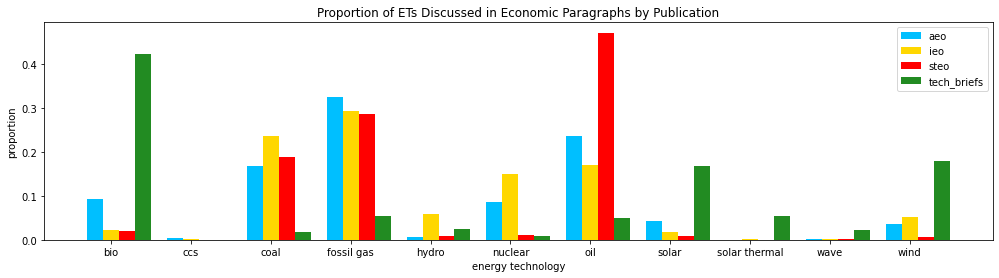

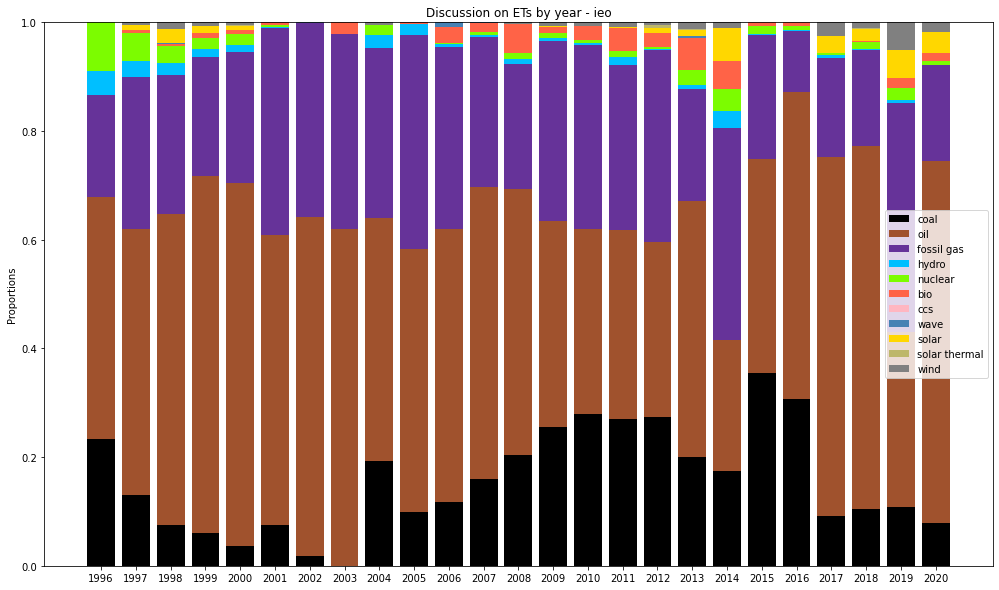

In [15]:
## Here let's look at out of the economic paragraphs for each publication, with what proportion do they
# talk about each energy technology ##
PUBLICATION = "ieo"
dataset_by_pub = economic_df.groupby("doc_category")['coref_energy_counts'].aggregate(lambda x: sum(x, Counter()))
total_by_pub = {}
for pub, data in dataset_by_pub.items():
    total_by_pub[pub] = sum(data.values())
plot_proportion_graph(dataset_by_pub, 12, "Proportion of ETs Discussed in Economic Paragraphs by Publication", "energy technology", "proportion")
d1 = lucy.get_energy_count_by_x(economic_df[economic_df['doc_category'] == "steo"], groupby="year", column="coref_energy_counts")
labels = [year for year in d1.keys()]
create_subset_stacked_bar(d1)


1996     14
1997     74
1998     27
1999    145
2000    139
2001    120
2002    131
2003    113
2004    118
2005     97
2006     93
2007     99
2008     92
2009     98
2010     94
2011     98
2012     99
2013    153
2014     73
2015     72
2016    430
2017     96
2018     38
2019     81
2020     20
dtype: int64

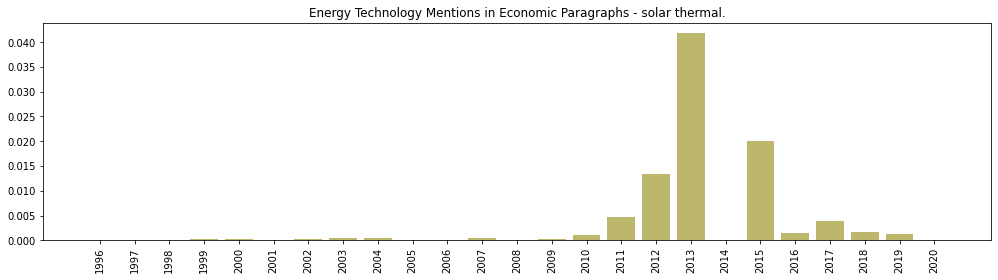

In [16]:
## I want to see how for a particular ET, the discussion surrounding Economy and that ET rises and falls over time.
# to supplement the graph, i will print the number of paragraphs for each year for that particular technology as 
# there might be large discrepancies between each year. ##

ENERGY = "solar thermal"
def create_plot_data(dataset, value_key):
    names, values = [], []
    for name, value in dataset.items():
        names.append(name)
        values.append(value[value_key] / sum(value.values()))
    return names, values

def create_supp_df(graph_ds,count_ds,value_key):
    new_dict = {}
    supp_df = pd.DataFrame()
    supp_df['totals'] = [f"{value_key}", "Total"]
    for name, value in graph_ds.items():
        supp_df[name] = [value[value_key], count_ds[name]]
    return supp_df

dataset_by_year = economic_df.groupby("year")["coref_energy_counts"].aggregate(lambda x: sum(x, Counter()))
count_by_year = economic_df.groupby("year").count()['coref_energy_counts'].to_dict()
plt.figure(55, figsize=STD_FIG_SIZE)
plt.title(f"Energy Technology Mentions in Economic Paragraphs - {ENERGY}.")
names, values = create_plot_data(dataset_by_year, ENERGY)
plt.xticks(rotation="90")
plt.bar(names, values, color=ET_COLOUR_MAPPING[ENERGY])
# create_supp_df(dataset_by_year,count_by_year,ENERGY)
supp_df = pd.Series(count_by_year)
supp_df

<BarContainer object of 25 artists>

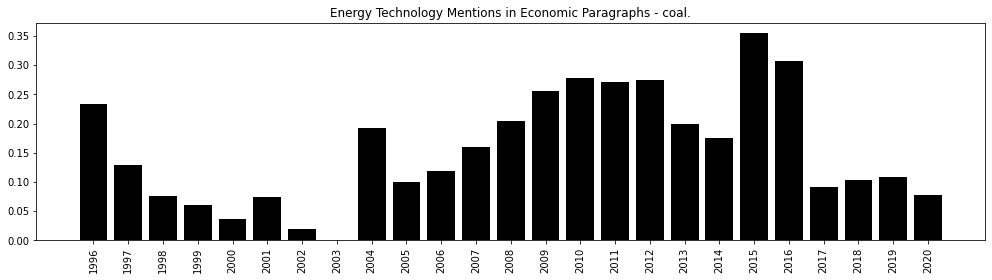

In [17]:
## ET mentions in economic paragraphs by publication over time ##
PUBLICATION = "steo"
ENERGY = "coal"
dataset = economic_df[economic_df["doc_category"] == PUBLICATION].groupby("year")['coref_energy_counts'].aggregate(lambda x: sum(x, Counter()))

plt.figure(113, figsize=STD_FIG_SIZE)
plt.title(f"Energy Technology Mentions in Economic Paragraphs - {ENERGY}.")
names, values = create_plot_data(dataset, ENERGY)
plt.xticks(rotation="90")
plt.bar(names, values, color=ET_COLOUR_MAPPING[ENERGY])
# labels = [year for year in dataset.keys()]
# create_subset_stacked_bar(dataset)
# create_subset_stacked_bar(dataset, RENEWABLE_SUBSET)
# create_subset_stacked_bar(dataset, FOSSIL_SUBSET)

In [18]:

def mention_gt1_et(row):
    curr_row_counts = row['coref_energy_counts']
    sorted_values = sorted(curr_row_counts.values(), reverse=True)
    if sorted_values[1] == 0:
        return False
    else:
        return True
    
def group_apply_multi_et(df_):
    m = df_.apply(mention_gt1_et, axis=1)
    return len(df_[m])

def group_apply_single_et(df_):
    m = df_.apply(mention_gt1_et, axis=1)
    return len(df_[m == False])

m = df.apply(mention_gt1_et, axis=1)
# single_et_df = df[m == False]
# multi_et_df = df[m]

## Let's see the proportion of paragraphs from each publication that talks about more than one ET ##
pub_count = df.groupby("doc_category").count()['organisation']
print(pub_count)
multi_et_paras = df.groupby("doc_category").apply(group_apply_multi_et)
single_et_paras = df.groupby("doc_category").apply(group_apply_single_et)
for k, v in multi_et_paras.items():
    print(f"proportion of paragraphs with multiple ETs mentioned - {k}: {v / pub_count[k]}")
for k, v in single_et_paras.items():
    print(f"proportion of paragraphs with single ET mentioned - {k}: {v / pub_count[k]}")
## Let's see the proportion of paragraphs that talk about more than one ET ##

doc_category
aeo            2641
ieo            1167
steo           3470
tech_briefs    1054
Name: organisation, dtype: int64
proportion of paragraphs with multiple ETs mentioned - aeo: 0.5043544112078758
proportion of paragraphs with multiple ETs mentioned - ieo: 0.609254498714653
proportion of paragraphs with multiple ETs mentioned - steo: 0.29769452449567724
proportion of paragraphs with multiple ETs mentioned - tech_briefs: 0.286527514231499
proportion of paragraphs with single ET mentioned - aeo: 0.49564558879212417
proportion of paragraphs with single ET mentioned - ieo: 0.390745501285347
proportion of paragraphs with single ET mentioned - steo: 0.7023054755043228
proportion of paragraphs with single ET mentioned - tech_briefs: 0.713472485768501


In [3]:
## Let's have a look at for a specific Energy Technology, what are the most prevalent words in the headers surrounding 
# those technologies ##
ENERGY = "oil"

def mentions_et(row):
    if row.coref_energy_counts[ENERGY] != 0:
        return True
    else:
        return False

m = df.apply(mentions_et, axis=1)
et_df = df[m]

In [20]:
from corpus import Corpus
headers = et_df['header_text'].tolist()
top_terms = Counter()
nlp = spacy.load("en_core_web_sm")
cor = Corpus(corpus=headers)
tdm = cor._tf(True, 1)
for doc in tdm:
    sorted_terms = {t:v for t,v in sorted(zip(list(cor.v.get_feature_names(
            )), doc.todense().tolist()[0]), key=lambda x: x[1], reverse=True)}
    top_terms.update(sorted_terms)
print(top_terms.most_common(20))


[('oil', 453), ('energy', 432), ('gas', 251), ('natural', 203), ('world', 201), ('prices', 183), ('petroleum', 167), ('demand', 159), ('outlook', 157), ('fuels', 150), ('production', 148), ('issues', 141), ('cases', 138), ('forecast', 134), ('crude', 132), ('fuel', 132), ('consumption', 128), ('highlights', 123), ('supply', 117), ('liquid', 115)]


In [21]:
PUBLICATION = "steo"
dataset = lucy.get_energy_count_by_x(df[df["doc_category"] == PUBLICATION], groupby=["year"], column="coref_energy_counts")
labels = [year for year in dataset.keys()]

In [5]:
## DEPENDENCY PARSING STUFF ##
dep_df = df.head(20)
patterns = []
for key in lucy.energy_clusters:
    patterns.extend(lucy.nlp.pipe(lucy.energy_clusters[key]))
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(lucy.nlp.vocab, attr="LEMMA")
matcher.add("energy_keywords",None,*patterns)
# for para in df[]['coref_para_text']:
#     lower_paras.append(para.lower())
lower_paras = [para.lower() for para in df[df["doc_category"] == "tech_briefs"]['coref_para_text']]
# et_adjs = {}

In [22]:
def reduce_matches(matches):
    """
    This function reduces the number of matches by removing matches that occur within another match.
    e.g if there is both a match for "oil" and "crude oil" in the same span, then we need to remove the "oil"
    match as the crude oil match takes precedence as it is longer.
    """
    prev_match = None
    reduced_matches = []
    for match in matches:
        if not prev_match:
            reduced_matches.append(match)
        elif match[1] > prev_match[2]:
            reduced_matches.append(match)
        elif (match[1] < prev_match[2]) and (match[2] > prev_match[2]):
            reduced_matches.append(match)
        prev_match = match
    return reduced_matches

def extract_dependencies(doc, chunk):
    allowed_deps = ["acomp", "amod", "meta", "neg", "nounmod", "npmod", "nummod", "poss", "prep", "relcl", "advcl"]
    match_descriptors = []
    # dep = {}
    # similar to lucy et. al 2020, we will focus on 3 main relations between words, that is:
    # 1. adjectival modifier of a particular noun (amod)
    # phrasal modifiers
    # if chunk.root.pos_ == "NOUN":
        # let's look for modifiers

    # renewable solar power is not great


    for child in chunk.root.lefts:
        # if the word is not part of the matched chunk, has a dependency relation outlined in modifiers and is an adjective, let's add
        # it to our words that describe that particular energy tech keyword.
        if (child not in chunk) and child.dep_ in allowed_deps:
            match_descriptors.append((chunk, child, child.dep_))
            # if child.dep_ not in dep:
            #     dep[child.dep_] = {"sent": child.sent, "chunk": chunk}
            # print("######")
            # print(f"chunk: {chunk}")
            # print(child.sent)
            # print(child, child.dep_)
    if chunk.root.head.pos_ == "VERB" or chunk.root.head.pos_ == "AUX":
        negation = None
        for child in chunk.root.head.rights:
            if (child not in chunk) and child.pos_ == "PART" and child.dep_ == "neg":
                negation = child
                continue
            if (child not in chunk) and child.pos_ == "ADJ" and child.dep_ in allowed_deps:
                if negation:
                    match_descriptors.append((chunk, [negation, child], child.dep_))
                else:
                    match_descriptors.append((chunk, child, child.dep_))
                    # print("######")
                    # print(f"chunk: {chunk}")
                    # print(child.sent)
                    # print(child, child.dep_)
        # 2. subject of verb (dobj)
        # 3. object of verb (nsubj)
        # if dep:
        #     pprint(dep)
        # if chunk.root.dep_ == "dobj" or chunk.root.dep_ == "nsubj":
        #     match_descriptors.append((chunk,chunk.root.head))
    return match_descriptors

def get_pos_from_sent(doc, match):
    """
    Solar panels are grey and not very good at things
    """
    match_start = match[1]
    match_end = match[2]
    match_word = doc[match_start:match_end]
    match_sent = doc[match_start:match_end].sent
    words = []
    for tok in match_sent:
        if not (tok.i >= match_start and tok.i < match_end) and tok.pos_ == "ADJ":
            words.append(tok.lemma_)
    return words

def get_pos_from_root(doc, match):
    match_start = match[1]
    match_end = match[2]
    match_root = doc[match_start:match_end].root
    breakpoint()
    words = Counter()
    for tok in match_sent:
        if tok.pos_ == "ADJ":
            words[tok.lemma_] += 1
    return words

i = 0

for doc in lucy.nlp.pipe(lower_paras[:100]):
    # print(i)
    matches = matcher(doc)
    sorted_matches = sorted(matches, key=lambda x: (x[1], -x[2]))
    reduced_matches = reduce_matches(sorted_matches)
    # noun_chunks = [(chunk.start, chunk.end) for chunk in doc.noun_chunks]
    for match in reduced_matches:
        match_start = match[1]
        match_end = match[2]
        chunk = doc[match_start:match_end]
        md = extract_dependencies(doc, chunk)
        if md:
            print(md)
    print("==========")
    i += 1




[(biomass, traditional, 'amod')]
[(solar, direct, 'amod')]
[(solar collectors, advanced, 'amod')]
[(gas, inert, 'amod')]
[(mirrors, flat, 'amod')]
[(solar collector, appropriate, 'amod')]
[(solar collector, required, 'amod')]
[(solar collector, required, 'amod')]
[(solar, industrial, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro storage, pumped, 'amod')]
[(gas, ﬂ, 'amod')]
[(wind turbines, individual, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(hydro, pumped, 'amod')]
[(gas, advanced, 'amod')]
[(wind, ofvariable, 'amod')]
[(biomass, other, 'amod'), (biomass, lignocellulosic, 'amod')]
[(biofuels, conventional, 'amod')]
[(biomass, lignocellulosic, 'amod')]
[(biofuels, red, 'amod')]
[(biofuels, based, 'amod')]
[(biofuels, swedish, 'amod')]
[(oils, ofvegetable, 'amod')]

In [54]:
tmp_et = []
tmp_keyword = []
tmp_adj = []
tmp_count = []
with open("energy_technology.json", "r") as fp:
    ets = json.load(fp)
for et_keyword in et_adjs:
    for et in ets:
        if et_keyword in ets[et]:
            curr_et = et
            break
    for adj, count in et_adjs[et_keyword].items():
        tmp_et.append(curr_et)
        tmp_keyword.append(et_keyword)
        tmp_adj.append(adj)
        tmp_count.append(count)
lucy2_df = pd.DataFrame({"energy_tech": tmp_et, "keyword": tmp_keyword, "adjective": tmp_adj, "count": tmp_count})
lucy2_df.to_pickle("lucy2.pickle")

In [60]:
lucy2_df[lucy2_df['energy_tech'] == "solar"]

,energy_tech,keyword,adjective,count
5776,solar,solar,total,137
5777,solar,solar,more,113
5778,solar,solar,solar,803
5779,solar,solar,new,195
5780,solar,solar,other,158
...,...,...,...,...
21267,solar,silicon,small,1
21268,solar,silicon,efficient,1
21269,solar,silicon,fast,1
21270,solar,silicon,private,1


In [18]:
topic_terms['3611 humanities']

['economic',
 'history',
 'conduct',
 'ethic',
 'geopolitic',
 'language',
 'economic theory',
 'behaviour',
 'sociology',
 'philosophy']

## Log odds ratio section
--------
In this section we are combining together the vocabularies of IEO, AEO and Journals datasets to then compare to a secondary corpus, the google n-gram or civility data corpora. In order to find what words in our datasets are most relevant. These will then be used to decide which Eurovoc labels are kept in our DTM topic Eurovoc vector representations.

In [1]:
import os
import pandas as pd
from collections import Counter
aeo_model = os.path.join(os.environ['ROADMAP_SCRAPER'], "DTM", "dtm", "greyroads_aeo_all_ngram")
ieo_model = os.path.join(os.environ['ROADMAP_SCRAPER'], "DTM", "dtm", "greyroads_ieo_all_ngram")
journals_model = os.path.join(os.environ['ROADMAP_SCRAPER'], "DTM", "dtm", "journal_energy_policy_applied_energy_all_years_abstract_all_ngram")
aeo = pd.read_csv(os.path.join(aeo_model, "vocab.txt"), sep="\t", names=["term", "count"])
ieo = pd.read_csv(os.path.join(ieo_model, "vocab.txt"), sep="\t", names=["term", "count"])
journals = pd.read_csv(os.path.join(journals_model, "vocab.txt"), sep="\t", names=["term", "count"])

In [2]:
counter = Counter({row.term: row.count for row in aeo.itertuples()})
counter.update({row.term: row.count for row in ieo.itertuples()})
counter.update({row.term: row.count for row in journals.itertuples()})

In [3]:
terms = []
counts = []
for t,c in counter.items():
    terms.append(t)
    counts.append(c)
merged_df = pd.DataFrame({"term": terms, "count": counts})
assert counter['energy'] == merged_df.loc[merged_df.term=="energy"]['count'].tolist()[0]

In [4]:
#merged_df.to_csv("greyroads_corpus.tsv", sep="\t", index=False, header=False)

In [7]:
civility_path = os.path.join(os.environ['ROADMAP_SCRAPER'], "DTM", "dtm", "civility_2011_2020_gt_600_ngram_min_freq_20", "vocab.txt")
civility_df = pd.read_csv(civility_path, sep="\t", names=["term", "count"])

In [9]:
counter.update({row.term: row.count for row in civility_df.itertuples()})
terms = []
counts = []
for t,c in counter.items():
    terms.append(t)
    counts.append(c)
union_df = pd.DataFrame({"term": terms, "count": counts})

In [10]:
log_odds_root = os.path.join(os.environ['ROADMAP_SCRAPER'], "DTM", "dtm", "log-odds")
civility_df.to_csv(os.path.join(log_odds_root, "civility_corpus.tsv"), sep="\t", index=False, header=False)
merged_df.to_csv(os.path.join(log_odds_root, "greyroads_corpus.tsv"), sep="\t", index=False, header=False)
union_df.to_csv(os.path.join(log_odds_root, "background_corpus.tsv"), sep="\t", index=False, header=False)

## Here we compute a couple of nice summary statistics for the IEO and AEO datasets.

In [7]:
sns.set_style("whitegrid")
sns.set_context("paper")
palette = sns.color_palette("viridis", as_cmap=True)

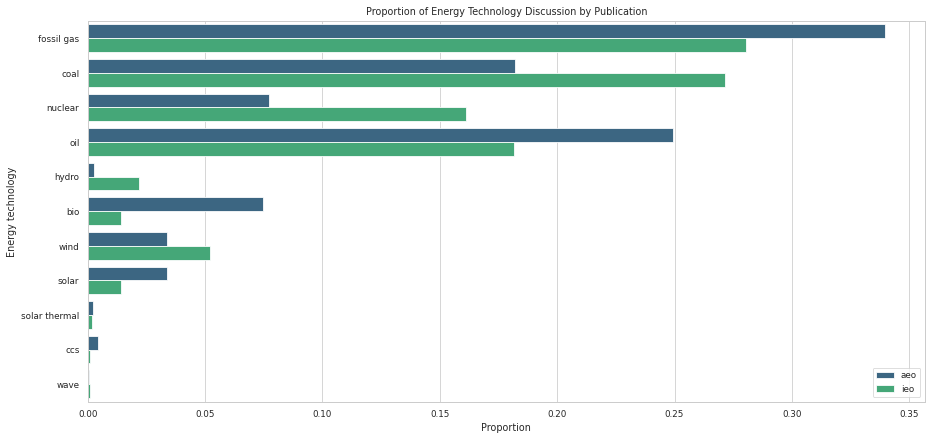

In [17]:
from collections import defaultdict
res = df.groupby("doc_category")['lucy_counts'].aggregate(lambda x: sum(x, Counter()))
df_list = []
aeo_total = sum(res['aeo'].values())
ieo_total = sum(res['ieo'].values())
aeo = [["aeo", i, res['aeo'][i] / aeo_total] for i in ET_INDICES]
ieo = [["ieo", i, res['ieo'][i] / ieo_total] for i in ET_INDICES]
df_list.extend(aeo)
df_list.extend(ieo)
# plt.tight_layout()
plot_df = pd.DataFrame(data=df_list, columns=["publication", "Energy technology", "Proportion"])
fig = plt.figure(figsize=(15,7))
g = sns.barplot(data=plot_df, palette="viridis", hue="publication", y="Energy technology", x="Proportion").set(title="Proportion of Energy Technology Discussion by Publication")
plt.legend(loc='lower right')
plt.savefig("./figures/aeo_ieo_et_discussion.png")

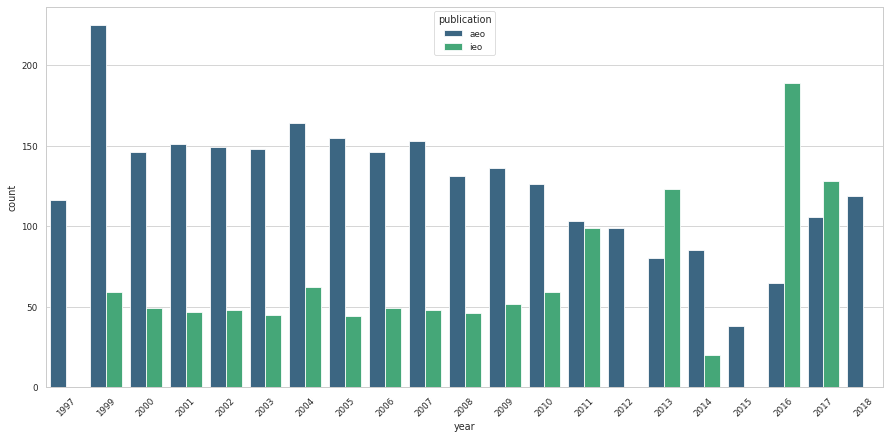

In [19]:
aeo = df[df['doc_category']=="aeo"].groupby('year')['lucy_counts'].count()
ieo = df[df['doc_category']=="ieo"].groupby('year')['lucy_counts'].count()
ieo_years = ieo.index.tolist()
aeo_years = aeo.index.tolist()
years = sorted(set(ieo_years + aeo_years), key=lambda x: int(x))
data = []
aeo = aeo.to_dict()
ieo = ieo.to_dict()
for year in years:
    try:
        data.append([year, 'aeo', aeo[year]])
    except:
        pass
    try:
        data.append([year, 'ieo', ieo[year]])
    except:
        pass
plot_df = data=pd.DataFrame(data=data, columns=['year', 'publication', 'count'])
plot_df
fig = plt.figure(figsize=(15,7))

g = sns.barplot(data=plot_df, palette="viridis", x="year", y="count", hue="publication")
plt.xticks(rotation=45)
plt.savefig("docs_ot.png")

In [105]:
ieo

{'1999': 59,
 '2000': 49,
 '2001': 47,
 '2002': 48,
 '2003': 45,
 '2004': 62,
 '2005': 44,
 '2006': 49,
 '2007': 48,
 '2008': 46,
 '2009': 52,
 '2010': 59,
 '2011': 99,
 '2013': 123,
 '2014': 20,
 '2016': 189,
 '2017': 128}